In [42]:
# Forked and modified from https://github.com/tensorflow/tensorflow/blob/r0.10/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

from __future__ import (absolute_import, division, print_function)

import collections
import math
import os
import random
import zipfile
import re

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("Done")

Done


In [76]:
import pandas
import nltk

#TODO(remove other errors, spelling mistakes, urls etc.)
#Pipes and stars.
# Split concatenated words http://stackoverflow.com/questions/8870261/how-to-split-text-without-spaces-into-list-of-words
def get_full_text_description(data_column):
  pattern = re.compile(r'(\w+)\/(\w+)')
  cleaned_text = ''  
  for cell in data_column:
    if pattern.search(cell):
        cell = pattern.sub(r'\1 \2', cell)
    cleaned_text += cell.lower() + ' '
  tokens = nltk.word_tokenize(unicode(cleaned_text, "utf-8"))
  text = nltk.Text(tokens)
  return text

In [81]:
data = pandas.read_csv('data/train.csv', nrows=50000) #Can read a subset. First nrows of the total.
words = get_full_text_description(data['FullDescription'])
print(words[0:100])

[u'engineering', u'systems', u'analyst', u'dorking', u'surrey', u'salary', u'****k', u'our', u'client', u'is', u'located', u'in', u'dorking', u',', u'surrey', u'and', u'are', u'looking', u'for', u'engineering', u'systems', u'analyst', u'our', u'client', u'provides', u'specialist', u'software', u'development', u'keywords', u'mathematical', u'modelling', u',', u'risk', u'analysis', u',', u'system', u'modelling', u',', u'optimisation', u',', u'miser', u',', u'pioneeer', u'engineering', u'systems', u'analyst', u'dorking', u'surrey', u'salary', u'****k', u'engineering', u'systems', u'analyst', u'/', u'mathematical', u'modeller', u'.', u'our', u'client', u'is', u'a', u'highly', u'successful', u'and', u'respected', u'consultancy', u'providing', u'specialist', u'software', u'development', u'miser', u',', u'pioneer', u',', u'maths', u',', u'mathematical', u',', u'optimisation', u',', u'risk', u'analysis', u',', u'asset', u'management', u',', u'water', u'industry', u',', u'access', u',', u'excel

In [82]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 25000

def build_dataset(words):
  count = [['UNK', -1]]
  word_counter = collections.Counter(words).most_common(vocabulary_size - 1)
  count.extend(word_counter)
  dictionary = dict()
  for word, _ in count:
    # Indexing words by their rank in terms of frequency.
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
del words  # Hint to reduce memory.

In [83]:
print('Most common words (+UNK)', count[:250])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 114040], (u'and', 535927), (u',', 462194), (u'.', 428261), (u'the', 418649), (u'to', 409871), (u'a', 303939), (u'of', 287504), (u'in', 207644), (u'for', 175592), (u'with', 147312), (u'you', 137300), (u'will', 132659), (u'be', 126719), (u'is', 121197), (u'this', 101327), (u'as', 97635), (u'****', 96492), (u'an', 88522), (u'are', 86802), (u':', 86748), (u'experience', 85761), (u'on', 79802), (u'have', 72780), (u'or', 65474), (u'role', 58634), (u'work', 56901), (u'your', 56173), (u'team', 54183), (u'business', 53562), (u'we', 48931), (u'skills', 48037), (u')', 46326), (u'our', 45940), (u'working', 45683), (u'(', 44852), (u'within', 44197), (u'all', 43856), (u'sales', 41302), (u'that', 40902), (u'client', 39240), (u'their', 37711), (u'management', 37704), (u'manager', 37232), (u'please', 34981), (u'at', 34518), (u'job', 34234), (u'company', 33773), (u'development', 32717), (u'from', 32644), (u'support', 31799), (u'looking', 31102), (u'excellent', 29679), (

In [84]:
# Step 3: Function to generate a training batch for the skip-gram model.
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
      '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

118 systems -> 354 analyst
118 systems -> 155 engineering
354 analyst -> 7779 dorking
354 analyst -> 118 systems
7779 dorking -> 354 analyst
7779 dorking -> 1110 surrey
1110 surrey -> 80 salary
1110 surrey -> 7779 dorking


In [36]:
# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                     num_sampled, vocabulary_size))

  # Construct the SGD optimizer using a learning rate of 1.0.
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Add variable initializer.
  init = tf.initialize_all_variables()

In [85]:
# Step 5: Begin training.
num_steps = 1000001

with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print("Initialized")

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print("Average loss at step ", step, ": ", average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log_str = "Nearest to %s:" % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = "%s %s," % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  243.027923584
Nearest to with: •experience, cancellations, ’, hang, staff, freight/logistics, deemed, stake,
Nearest to technical: snmp, obstructive, believing, dependent, ave, mannered, signage, come,
Nearest to was: little’, stb, earned, mobilize, fontsize:12., pru, mifid, telemarketer,
Nearest to project: 4/****, np, retail, correspondence, hut, nonit, admired, unspoilt,
Nearest to it: dudley, monthsrate, gwaith, ies, vikki, coins, ely, submittals,
Nearest to recruitment: home.the, october, selected, kuwait, clare.sinanancplni.com, tearooms, volumes, socialising,
Nearest to our: rebuilding, troubled, staffordshire, maldives, uninsured, there, contents, portals,
Nearest to clients: 2003, agincare, complimentary, question, whiskas, triathlon, beefeater, ic,
Nearest to that: formulates, instigated, pcba, ecm, seals, concession, costeffectively, duel,
Nearest to apply: team”, skilful, encouraging, teenage, buying, foreseeable, rti, translators,
Nea

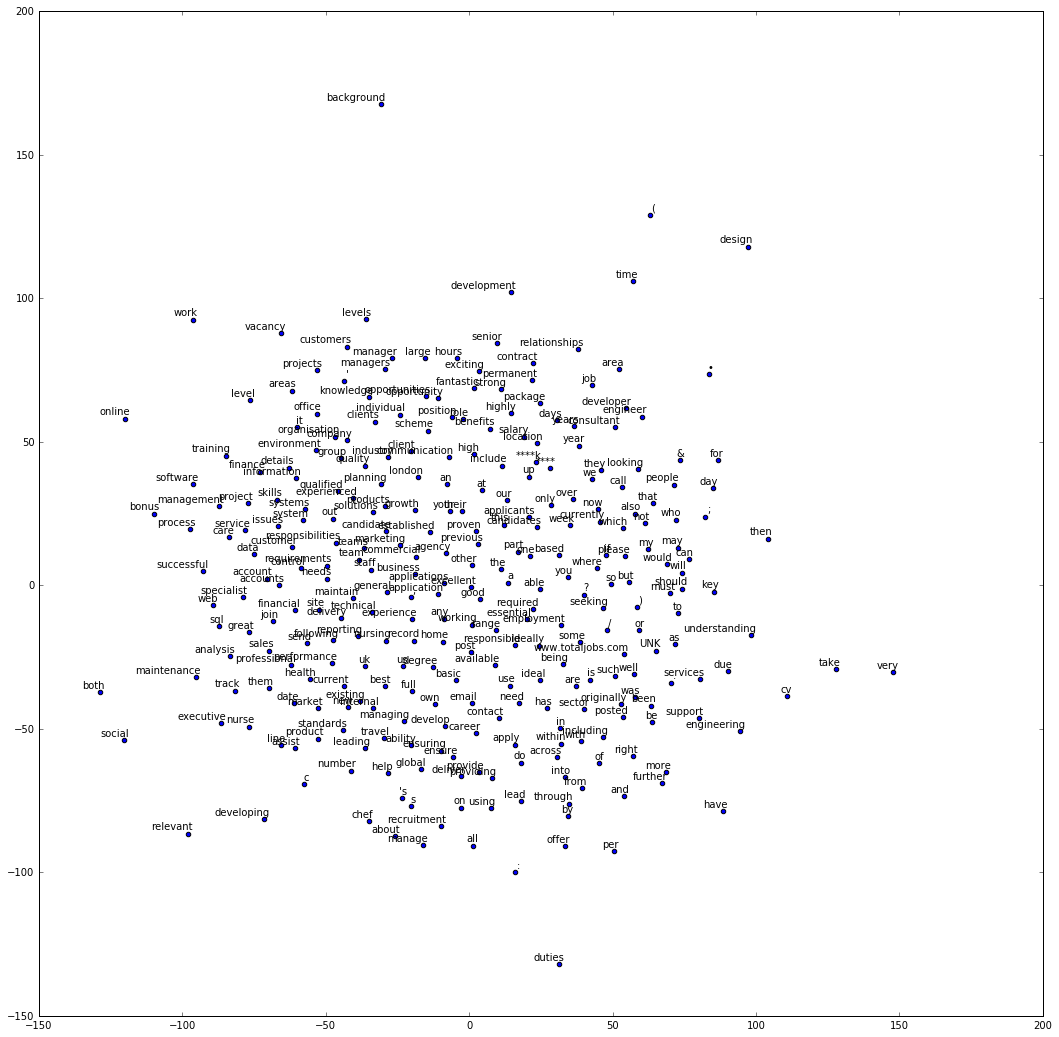

In [89]:
# Step 6: Visualize the embeddings.
%matplotlib inline

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  #in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
  plt.show()
  plt.savefig(filename)

try:
  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
  plot_only = 300
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")

In [39]:
print(final_embeddings.shape)
print(labels)

(25000, 128)
['UNK', u'and', u',', u'.', u'the', u'to', u'a', u'of', u'in', u'for', u'with', u'you', u'will', u'be', u'is', u'****', u':', u'this', u'are', u'an', u'as', u'experience', u'on', u'have', u'or', u'work', u'your', u'role', u'team', u'we', u')', u'working', u'our', u'(', u'skills', u'business', u'all', u'within', u'that', u'manager', u'client', u'please', u'their', u'at', u'management', u'care', u'sales', u'support', u'company', u'from', u'looking', u'development', u'excellent', u'required', u'service', u'must', u'if', u'/', u'opportunity', u'apply', u'new', u';', u'by', u'job', u'successful', u'who', u'it', u'recruitment', u'not', u'knowledge', u'home', u'uk', u'based', u'ability', u'cv', u'customer', u'services', u'ensure', u'salary', u'candidate', u'training', u'environment', u'able', u'good', u'including', u'they', u'strong', u'join', u'high', u'also', u'has', u'clients', u'position', u'other', u'provide', u'well', u'project', u'full', u'&', u'staff', u'can', u'design', 